# 🚚 Проект: предсказание опозданий доставки

В этом проекте проводится анализ логистических данных с целью предсказания того, будет ли доставка произведена вовремя. Основное внимание уделено повышению полноты (recall) модели при контроле за точностью (precision).

## 📈 Проверка статистических гипотез

In [1]:
# импорт библиотек и метрик
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score, mean_absolute_error)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import clone

from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution
from optuna.integration import OptunaSearchCV

import time
from tqdm import tqdm
import re

from sklearn.datasets import fetch_california_housing

from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier

from scipy.stats import chi2_contingency, ttest_1samp

from IPython.display import display, Markdown

import re
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.utils.validation')

## 📁 Загрузка и первичный анализ данных

In [2]:
data = pd.read_csv('Delivery.csv')

In [3]:
display(data.head(10))
data.info()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
5,6,F,Flight,3,1,162,3,medium,F,12,1417,1
6,7,D,Flight,3,4,250,3,low,F,3,2371,1
7,8,F,Flight,4,1,233,2,low,F,48,2804,1
8,9,A,Flight,3,4,150,3,low,F,11,1861,1
9,10,B,Flight,3,2,164,3,medium,F,29,1187,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [4]:
data = data.drop('ID', axis = 1)

In [5]:
def to_snake_case(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

data.columns = [to_snake_case(col) for col in data.columns]
data = data.rename(columns={'reached.on._time_y.n' : 'time', 'weight_in_gms' : 'weight', 'mode_of__shipment' : 'mode_of_shipment', 'cost_of_the__product' : 'price','discount_offered' : 'discount'})
display(data.head(0))

,warehouse_block,mode_of_shipment,customer_care_calls,customer_rating,price,prior_purchases,product_importance,gender,discount,weight,time


## 🔍 Предобработка данных и очистка

In [6]:
def preprocessor(df):
    print('Количество пропусков в каждом из столбцов:')
    print(df.isna().sum())
    print("-" * 50)
    
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print("-" * 50)

    for col in df.select_dtypes(include='object').columns:
        print(f"Столбец: {col}")
        print(df[col].unique())
        print("-" * 50)

In [7]:
preprocessor(data)

Количество пропусков в каждом из столбцов:
warehouse_block        0
mode_of_shipment       0
customer_care_calls    0
customer_rating        0
price                  0
prior_purchases        0
product_importance     0
gender                 0
discount               0
weight                 0
time                   0
dtype: int64
--------------------------------------------------
Количество дубликатов: 0
--------------------------------------------------
Столбец: warehouse_block
['D' 'F' 'A' 'B' 'C']
--------------------------------------------------
Столбец: mode_of_shipment
['Flight' 'Ship' 'Road']
--------------------------------------------------
Столбец: product_importance
['low' 'medium' 'high']
--------------------------------------------------
Столбец: gender
['F' 'M']
--------------------------------------------------


## 📊 Анализ целевого признака (вовремя / не вовремя)

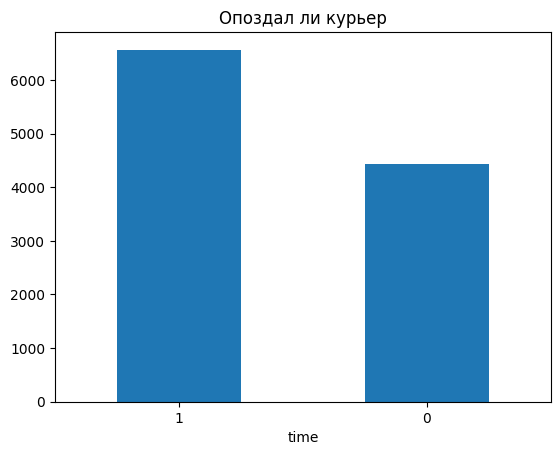

time
1    6563
0    4436
Name: count, dtype: int64

In [8]:
data['time'].value_counts().plot(kind='bar')
plt.title('Опоздал ли курьер')
plt.xticks(rotation=0)
plt.show()
data['time'].value_counts()

## 📊 Исследовательский анализ категориальных признаков

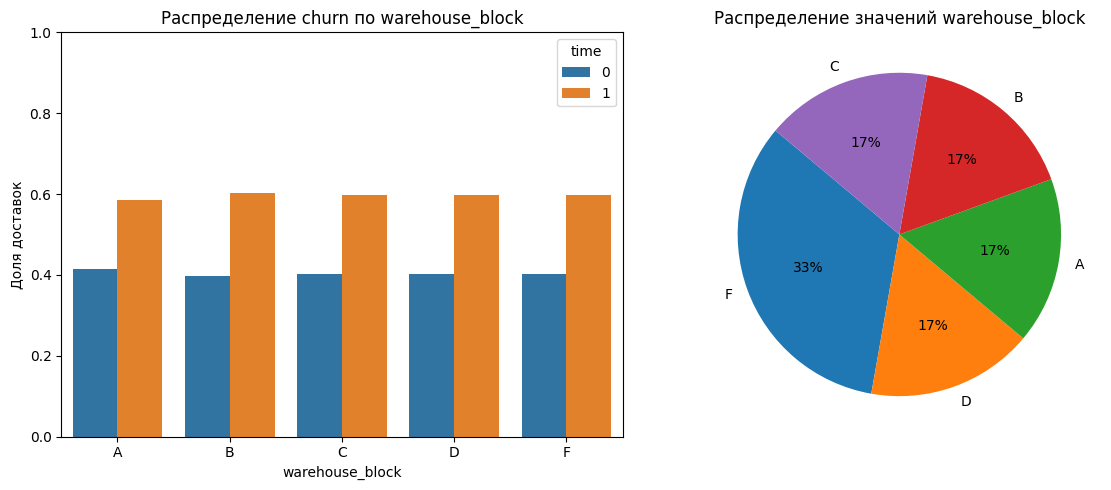

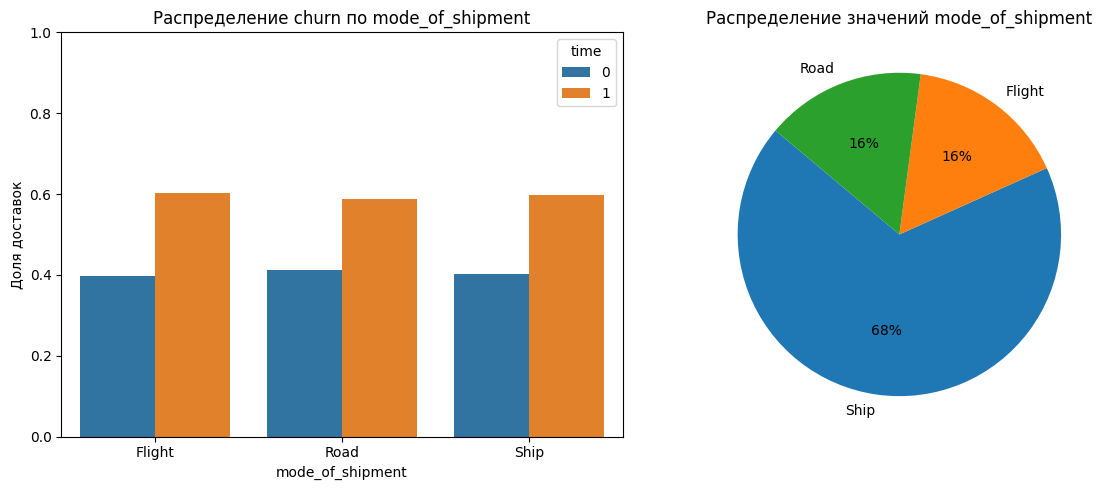

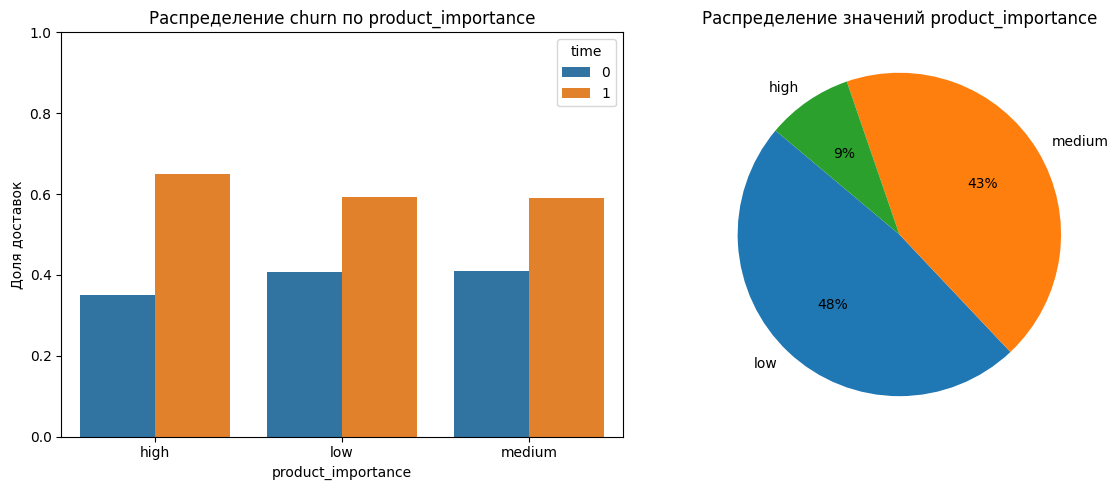

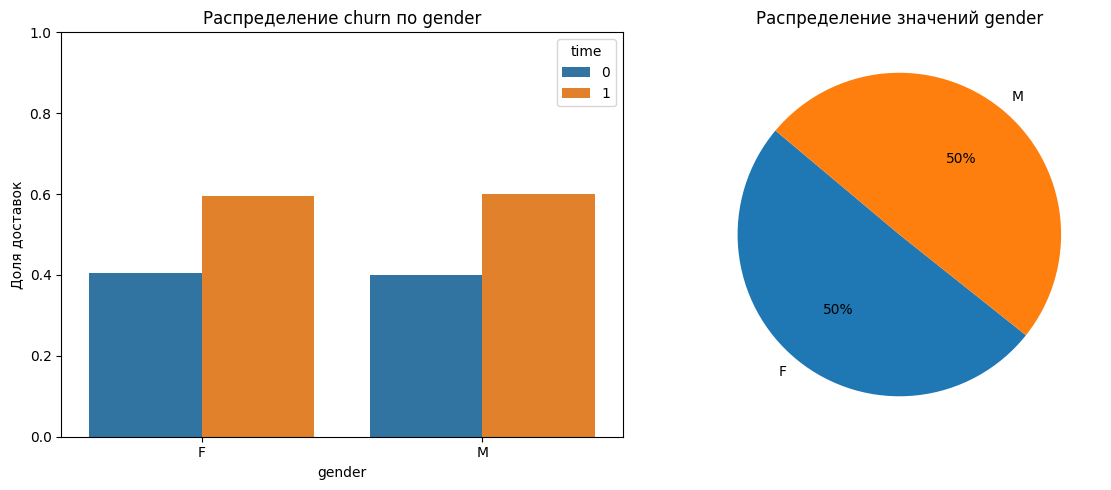

In [9]:
categorical_cols = data.select_dtypes(include='object').columns

for col in categorical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    churn_dist = (
        data.groupby(col)['time']
        .value_counts(normalize=True)
        .rename('proportion')
        .reset_index()
    )

    sns.barplot(
        x=col,
        y='proportion',
        hue='time',
        data=churn_dist,
        ax=axes[0]
    )
    axes[0].set_title(f'Распределение churn по {col}')
    axes[0].set_ylabel('Доля доставок')
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].set_ylim(0, 1) 

    pie_counts = data[col].value_counts()
    wedges, texts, autotexts = axes[1].pie(
        pie_counts,
        labels=pie_counts.index,
        autopct='%1.0f%%',
        startangle=140
    )
    axes[1].set_title(f'Распределение значений {col}')
    for text in texts + autotexts:
        text.set_fontsize(10)

    plt.tight_layout()
    plt.show()

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_care_calls,10999.0,4.054459,1.141490,2.0,3.0,4.0,5.0,7.0
customer_rating,10999.0,2.990545,1.413603,1.0,2.0,3.0,4.0,5.0
price,10999.0,210.196836,48.063272,96.0,169.0,214.0,251.0,310.0
prior_purchases,10999.0,3.567597,1.522860,2.0,3.0,3.0,4.0,10.0
discount,10999.0,13.373216,16.205527,1.0,4.0,7.0,10.0,65.0
weight,10999.0,3634.016729,1635.377251,1001.0,1839.5,4149.0,5050.0,7846.0
time,10999.0,0.596691,0.490584,0.0,0.0,1.0,1.0,1.0


## 📊 Исследование числовых признаков

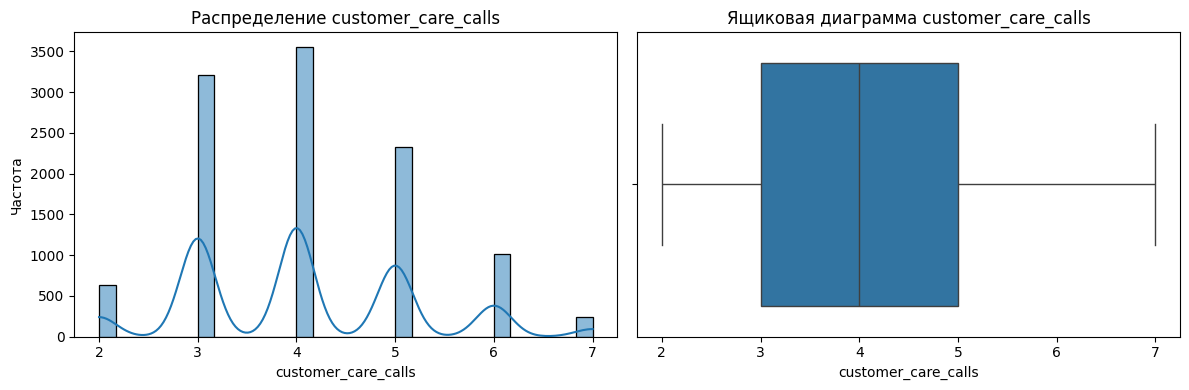

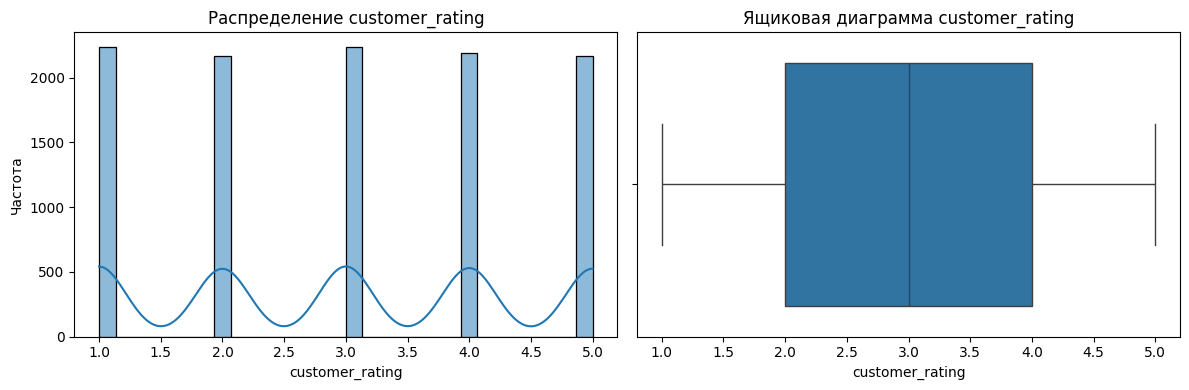

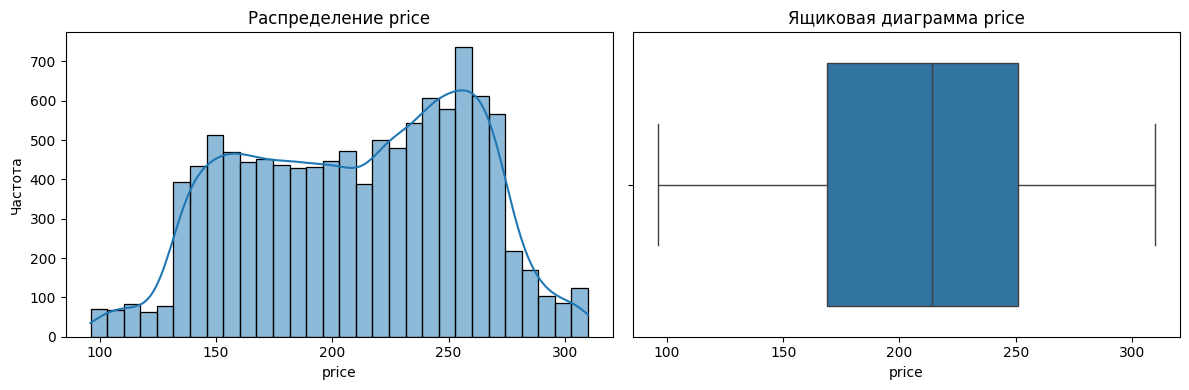

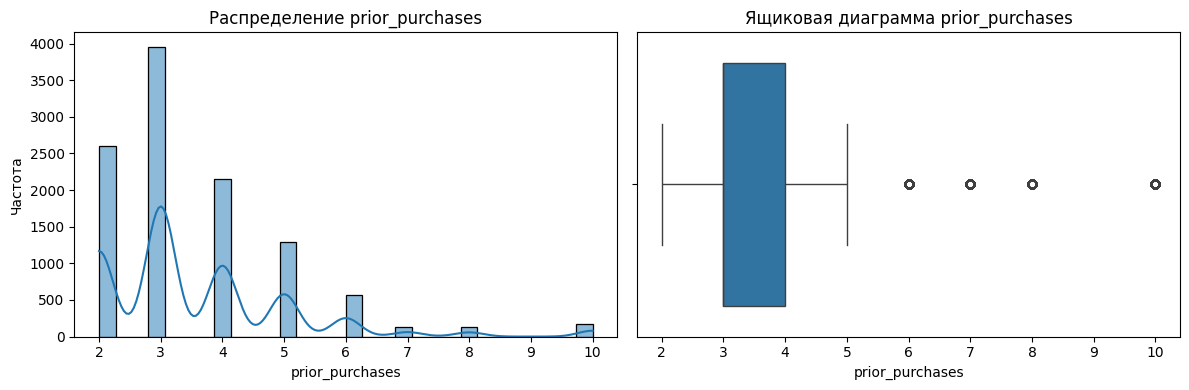

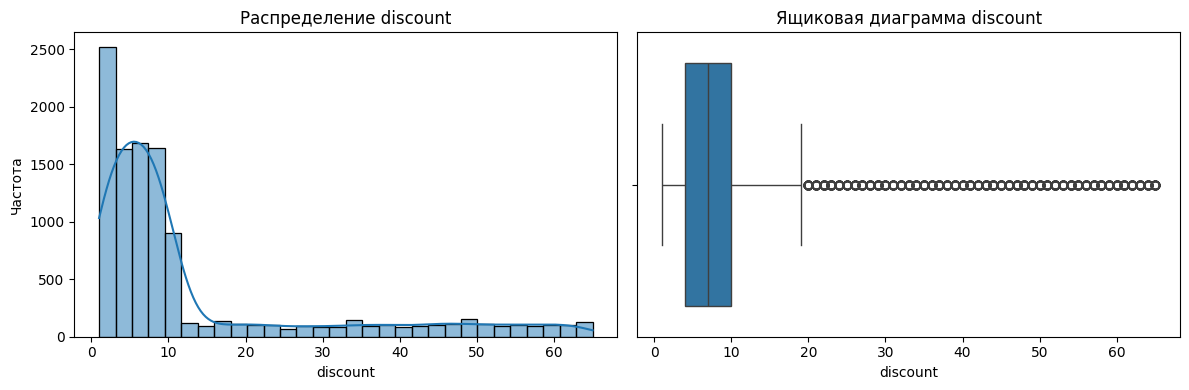

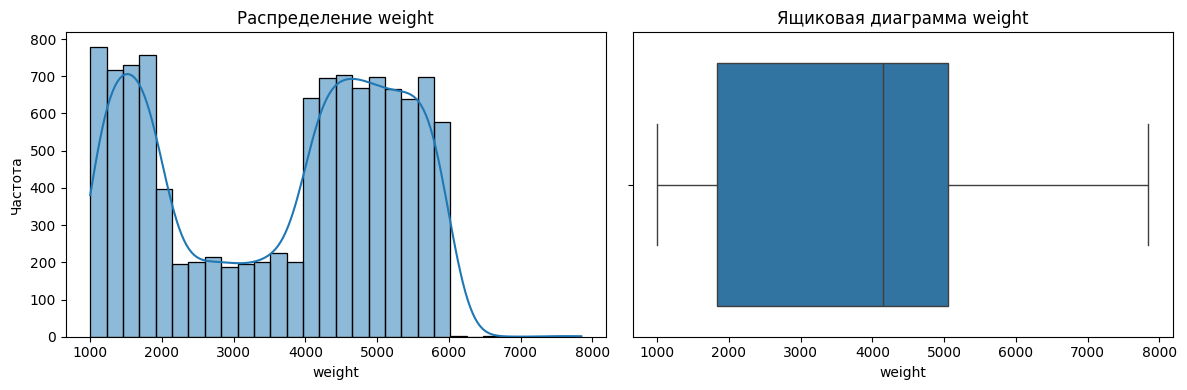

In [11]:
numerical_cols = data.select_dtypes(include='number').columns.drop('time', errors='ignore')

for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Гистограмма
    sns.histplot(data[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f'Распределение {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Частота')
    
    # Диаграмма размаха
    sns.boxplot(x=data[col], ax=axes[1])
    axes[1].set_title(f'Ящиковая диаграмма {col}')
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

In [12]:
def classify_weight(weight):
    if weight < 2000:
        return 'light'
    elif weight < 4000:
        return 'medium'
    else:
        return 'heavy'

data['weight_class'] = data['weight'].apply(classify_weight)
cols = list(data.columns)

i, j = cols.index('time'), cols.index('weight_class')

cols[i], cols[j] = cols[j], cols[i]

data = data[cols]

display(data[['weight', 'weight_class']].head(5))
display(data[['weight', 'weight_class']].query('weight >= 4000').head(5))

,weight,weight_class
0,1233,light
1,3088,medium
2,3374,medium
3,1177,light
4,2484,medium


,weight,weight_class
198,7640,heavy
199,7846,heavy
205,7588,heavy
213,7401,heavy
244,6064,heavy


## 📌 Корреляционный анализ и важность признаков

/var/folders/1j/wgf74c1d3f116n7z14dqwqcr0000gn/T/ipykernel_14915/973055969.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


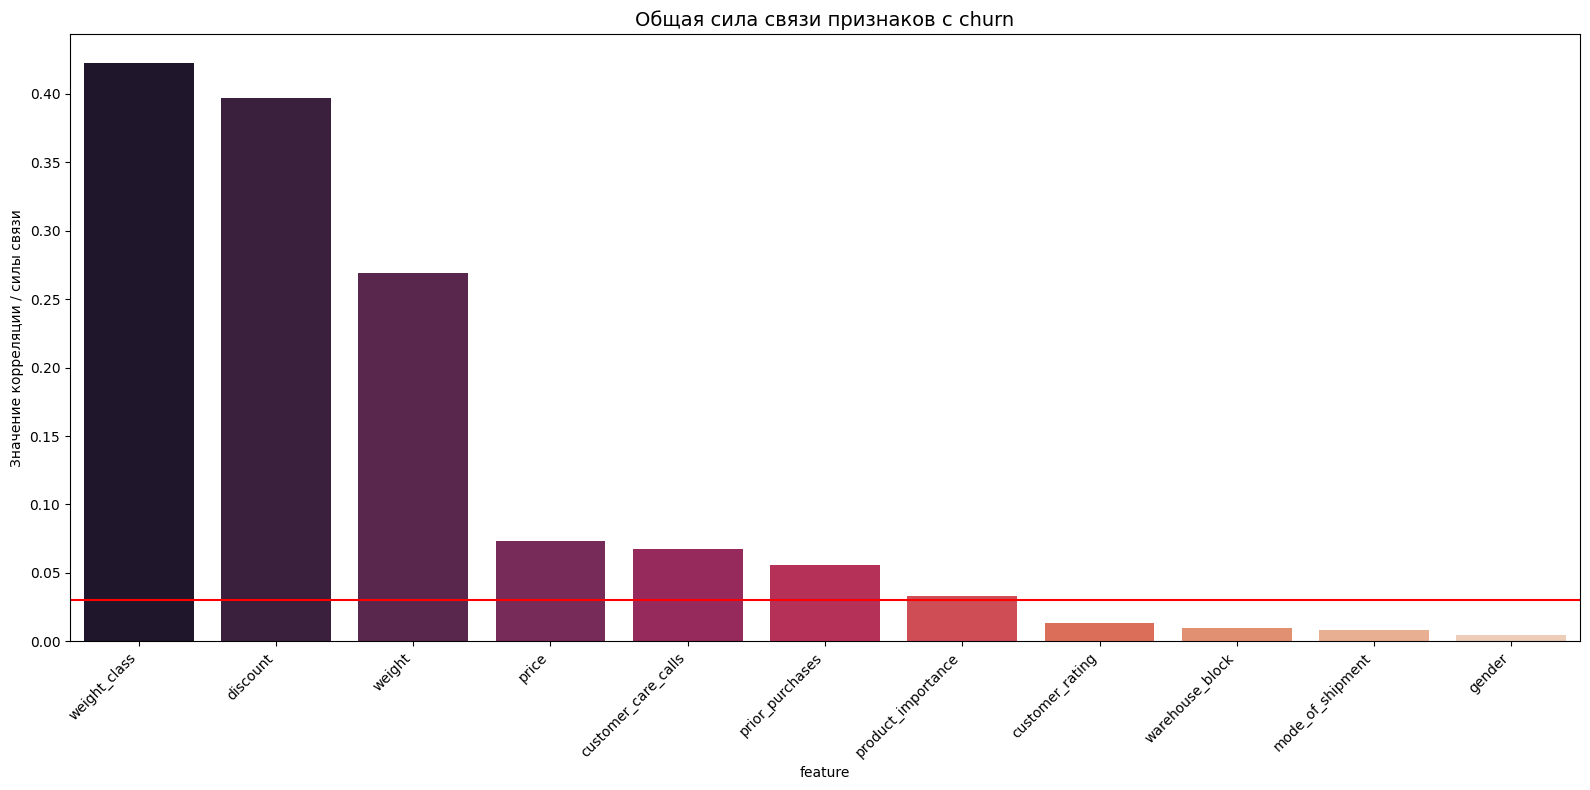

In [13]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

numeric_cols = data.select_dtypes(include='number').columns.drop('time')
num_corr = data[numeric_cols].corrwith(data['time']).abs()
num_corr = pd.DataFrame({'feature': num_corr.index, 'correlation': num_corr.values})

cat_cols = data.select_dtypes(include='object').columns
cat_corr = {col: cramers_v(data[col], data['time']) for col in cat_cols}
cat_corr = pd.DataFrame({'feature': list(cat_corr.keys()), 'correlation': list(cat_corr.values())})

all_corr = pd.concat([num_corr, cat_corr], ignore_index=True)
all_corr = all_corr.sort_values(by='correlation', ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=all_corr,
    x='feature',
    y='correlation',
    palette=sns.color_palette('rocket', n_colors=len(all_corr)) 
)
plt.axhline(y=0.03, color='red', linestyle='-')
plt.xticks(rotation=45, ha='right')
plt.title('Общая сила связи признаков с churn', fontsize=14)
plt.ylabel('Значение корреляции / силы связи')
plt.tight_layout()
plt.show()

In [14]:
data = data.drop(['warehouse_block', 'customer_care_calls', 'product_importance', 'customer_rating'], axis = 1)

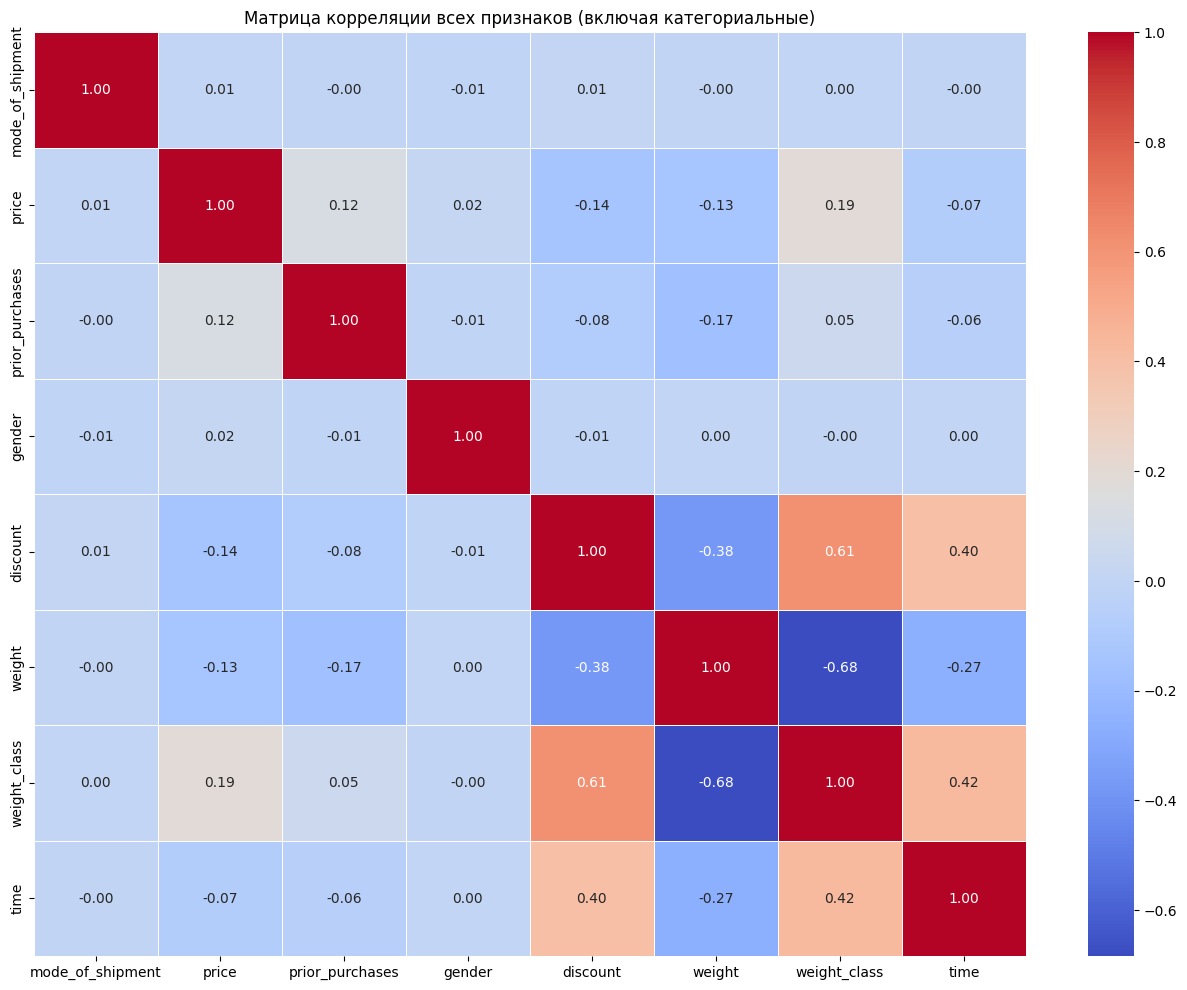

In [15]:
corr_data = data.copy()

cat_cols = corr_data.select_dtypes(include='object').columns
encoder = OrdinalEncoder()
corr_data[cat_cols] = encoder.fit_transform(corr_data[cat_cols])

corr_matrix = corr_data.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляции всех признаков (включая категориальные)")
plt.show()

## 📈 Проверка статистических гипотез

In [16]:
a = 0.05

contingency_table = pd.crosstab(data['mode_of_shipment'], data['time'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"p-value: {p:.4f}")
if p < a:
    print("❗ Зависимость между опозданием и типом доставки статистически значима.")
else:
    print("✅ Нет статистически значимой зависимости между опозданием и типом доставки.")

p-value: 0.6895
✅ Нет статистически значимой зависимости между опозданием и типом доставки.


In [17]:
delayed_prices = data[data['time'] == 1]['price']

t_stat, p = ttest_1samp(delayed_prices, 207)

print(f"p-value: {p:.4f}")
if p < a:
    print("❗ Средняя цена у опоздавших товаров статистически отличается от 207.")
else:
    print("✅ Средняя цена у опоздавших товаров статистически не отличается от 207.")

p-value: 0.6259
✅ Средняя цена у опоздавших товаров статистически не отличается от 207.


In [18]:
contingency_table = pd.crosstab(data['weight_class'], data['time'])

chi2, p, _, _ = chi2_contingency(contingency_table)

print("Хи-квадрат:", chi2)
print("p-value:", p)

if p < 0.05:
    print("✅ Зависимость между типом веса и опозданием статистически значима.")
    print("🔍 Частота опозданий по весовым категориям:")
    display(contingency_table.div(contingency_table.sum(axis=1), axis=0)) 
else:
    print("❌ Зависимость между типом веса и опозданием не подтверждена статистически.")

Хи-квадрат: 1964.8291330257268
p-value: 0.0
✅ Зависимость между типом веса и опозданием статистически значима.
🔍 Частота опозданий по весовым категориям:


time,0,1
weight_class,,
heavy,0.568029,0.431971
light,0.322123,0.677877
medium,0.001117,0.998883


In [19]:
display(data.head(10))

,mode_of_shipment,price,prior_purchases,gender,discount,weight,weight_class,time
0,Flight,177,3,F,44,1233,light,1
1,Flight,216,2,M,59,3088,medium,1
2,Flight,183,4,M,48,3374,medium,1
3,Flight,176,4,M,10,1177,light,1
4,Flight,184,3,F,46,2484,medium,1
5,Flight,162,3,F,12,1417,light,1
6,Flight,250,3,F,3,2371,medium,1
7,Flight,233,2,F,48,2804,medium,1
8,Flight,150,3,F,11,1861,light,1
9,Flight,164,3,F,29,1187,light,1


## ✂️ Разделение данных на обучающую и тестовую выборки

In [20]:
target = 'time'

RANDOM_STATE = 42
TEST_SIZE = 0.2

X = data.drop(columns=[target], axis = 1) 
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

In [21]:
ohe_col = X.select_dtypes(include='object').columns.difference(['weight_class']).tolist()
ord_col = ['weight_class']
num_col = X.select_dtypes(exclude='object').columns.tolist()

print(ohe_col)
print(ord_col)
print(num_col)

['gender', 'mode_of_shipment']
['weight_class']
['price', 'prior_purchases', 'discount', 'weight']


## ⚙️ Построение пайплайна предобработки

In [22]:
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

ord_pipe = Pipeline([
    ('imputer1', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['light', 'medium', 'heavy']],
                           handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer2', SimpleImputer(strategy='most_frequent'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_col),
    ('ord', ord_pipe, ord_col),
    ('num', num_pipe, num_col)
], remainder='drop')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

param_grid = [
    {
        'models': [CatBoostClassifier(verbose=0)],
        'models__depth': [4, 6, 8],
        'models__learning_rate': [0.03, 0.1],
        'models__iterations': [100, 200]
    },
    {
        'models': [LGBMClassifier(verbose=-1)],
        'models__n_estimators': [100, 200],
        'models__max_depth': [5, 10],
        'models__learning_rate': [0.05, 0.1]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'models__C': range(1, 15),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],
        'models__max_depth': [5, 10],
        'models__min_samples_split': [2, 5]
    }
]

## 🤖 Подбор модели с кросс-валидацией и GridSearch

In [23]:
grid = GridSearchCV(
    pipe_final,
    param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['gender',
                                                                          'mode_of_shipment']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('imputer1',
                                                                                          SimpleImputer(strategy='most_freque...
                          'models__n_estimators': [100, 200]},
                         {'models': [LogisticRegression(random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 15),
                          'preprocessor__num__scaler': [StandardScaler(),
                                                        MinMaxScaler()]},
                         {'models': [RandomForestClassifier(random_state=42)],
                          'models__max_depth': [5, 10],
                          'models__min_samples_split': [2, 5],
                          'models__n_estimators': [100, 200]}],
             scoring='recall', verbose=2)

In [24]:
cv_results = pd.DataFrame(grid.cv_results_)

best_per_model = (
    cv_results
    .assign(model_name=cv_results['param_models'].apply(lambda x: x.__class__.__name__))
    .sort_values('mean_test_score', ascending=False)
    .drop_duplicates(subset='model_name', keep='first')
    [['model_name', 'params', 'mean_test_score']]
    .rename(columns={
        'model_name': 'Model',
        'params': 'Best Params',
        'mean_test_score': 'Recall (CV)'
    })
    .reset_index(drop=True)
)

best_per_model = best_per_model.sort_values('Recall (CV)', ascending=False).reset_index(drop=True)

display(best_per_model)

best_model_name = best_per_model.iloc[0]['Model']
display(Markdown(f"**Лучшая модель по метрике Recall: `{best_model_name}`**"))

,Model,Best Params,Recall (CV)
0,LogisticRegression,"{'models': LogisticRegression(random_state=42,...",0.682286
1,LGBMClassifier,"{'models': LGBMClassifier(verbose=-1), 'models...",0.645905
2,CatBoostClassifier,{'models': <catboost.core.CatBoostClassifier o...,0.634476
3,RandomForestClassifier,{'models': RandomForestClassifier(random_state...,0.564000


**Лучшая модель по метрике Recall: `LogisticRegression`**

## 📌 Важность признаков модели логистической регрессии

discount                 6.784913
weight                   0.812307
prior_purchases          0.646018
price                    0.546911
weight_class             0.153958
mode_of_shipment_Road    0.061768
gender_M                 0.040598
mode_of_shipment_Ship    0.032948
dtype: float64


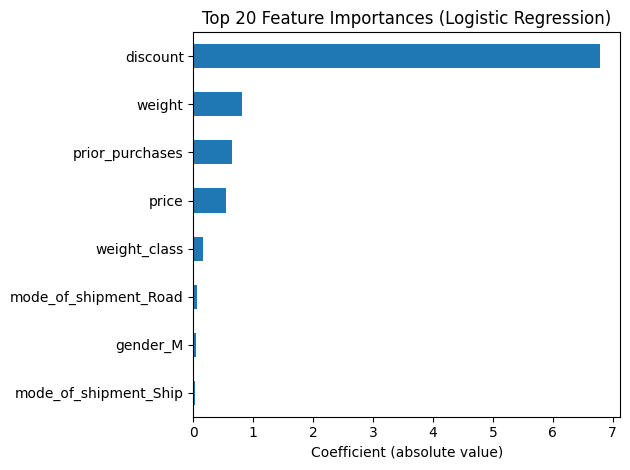

In [25]:
best_model = grid.best_estimator_

logreg_model = best_model.named_steps['models']

preprocessor = best_model.named_steps['preprocessor']

ohe_feature_names = preprocessor.named_transformers_['ohe'] \
    .named_steps['ohe'].get_feature_names_out(ohe_col)

num_feature_names = num_col

ord_feature_names = ord_col

all_feature_names = list(ohe_feature_names) + ord_feature_names + num_feature_names

coefficients = logreg_model.coef_[0]  
feature_importance = pd.Series(abs(coefficients), index=all_feature_names).sort_values(key=abs, ascending=False)

print(feature_importance.head(20))

feature_importance.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.xlabel("Coefficient (absolute value)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 🧪 Уточнение логистической регрессии с регуляризацией

In [26]:
param_grid_lr = [
    {
        'models': [LogisticRegression(penalty='l1', solver='liblinear', random_state=RANDOM_STATE)],
        'models__C': np.logspace(-2, 2, 10),  
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [LogisticRegression(penalty='l2', solver='liblinear', random_state=RANDOM_STATE)],
        'models__C': np.logspace(-2, 2, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    }
]

## 🤖 Подбор модели с кросс-валидацией и GridSearch

In [27]:
grid_lr = GridSearchCV(
    pipe_final,
    param_grid_lr,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=2
)
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['gender',
                                                                          'mode_of_shipment']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('imputer1',
                                                                                          SimpleImputer(strategy='most_freque...
                          'preprocessor__num__scaler': [StandardScaler(),
                                                        MinMaxScaler()]},
                         {'models': [LogisticRegression(random_state=42,
                                                        solver='liblinear')],
                          'models__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                          'preprocessor__num__scaler': [StandardScaler(),
                                                        MinMaxScaler()]}],
             scoring='recall', verbose=2)

In [28]:
print("Best recall (CV):", grid_lr.best_score_)
print("Best params:", grid_lr.best_params_)

Best recall (CV): 0.714857142857143
Best params: {'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': np.float64(0.01), 'preprocessor__num__scaler': MinMaxScaler()}


In [29]:
y_proba = grid_lr.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.0, 1.01, 0.01)
results = []

for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    results.append((thresh, recall, precision))

df_metrics = pd.DataFrame(results, columns=['threshold', 'recall', 'precision'])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [30]:
df_filtered = df_metrics[df_metrics['recall'] >= 0.75]

best_row = df_filtered.loc[df_filtered['precision'].idxmax()]
print("Лучший порог:", best_row)

Лучший порог: threshold    0.490000
recall       0.752475
precision    0.677176
Name: 49, dtype: float64


## 🎯 Оптимизация порога классификации

In [31]:
y_test_proba = grid_lr.predict_proba(X_test)[:, 1]

threshold = 0.49
y_test_pred = (y_test_proba >= threshold).astype(int)

Recall на тесте: 0.7525
Precision на тесте: 0.6772


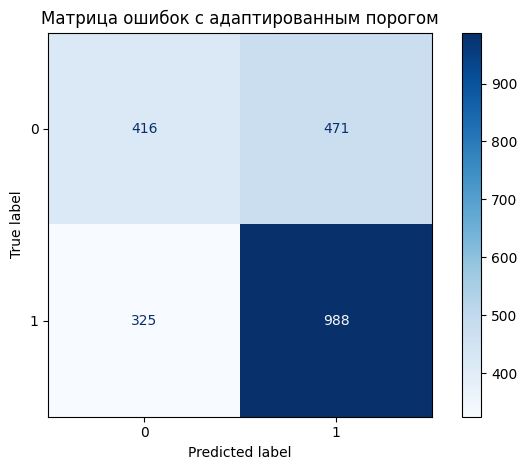

In [32]:
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)

print(f"Recall на тесте: {recall:.4f}")
print(f"Precision на тесте: {precision:.4f}")

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(
    cmap=plt.cm.Blues,
    colorbar=True,
    values_format='d'
)
plt.title("Матрица ошибок с адаптированным порогом")
plt.tight_layout()
plt.show()

## 📈 PR-кривая и ROC-кривая

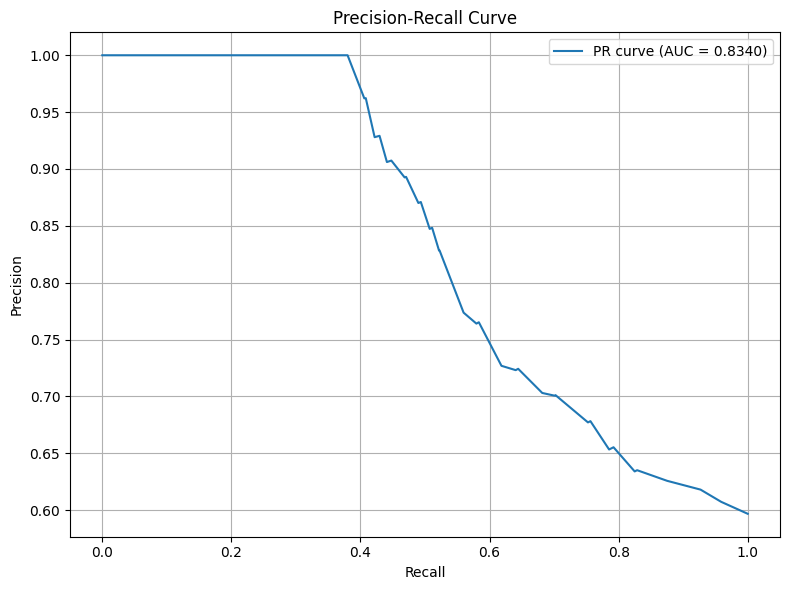

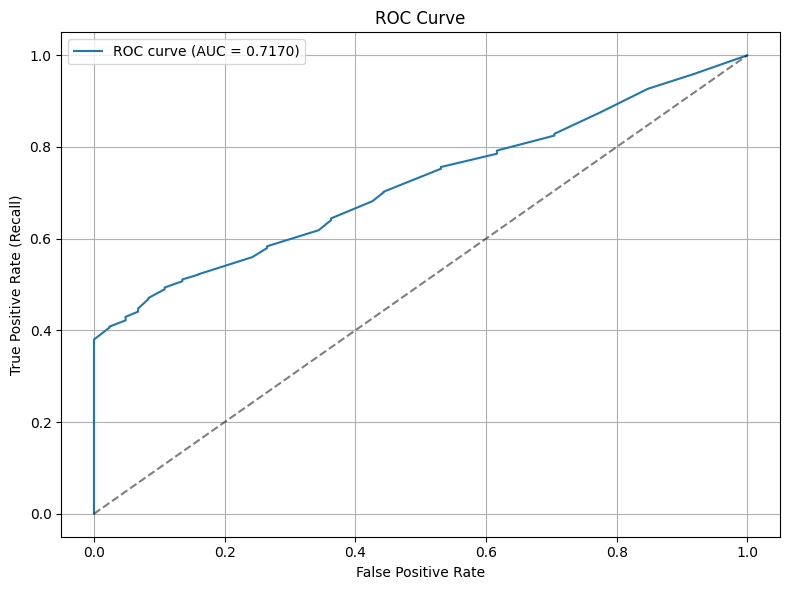

In [33]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

y_proba = grid_lr.best_estimator_.predict_proba(X_test)[:, 1]

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()